In [94]:
import os
import csv
import numpy as np
import pandas as pd
import xarray as xr
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation
from scipy.integrate import trapz
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from pykalman import KalmanFilter
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.common import Q_continuous_white_noise
from scipy.linalg import block_diag
#from pykalman import ExtendedKalmanFilter

In [95]:
data_directory = "./IMU_Recordings"
file_names = ["01IMU.csv", "02IMU.csv", "03IMU.csv", "04IMU.csv", "05IMU.csv", "06IMU.csv", "07IMU.csv", "08IMU.csv", "09IMU.csv", "10IMU.csv", "11IMU.csv", "12IMU.csv", "13IMU.csv", "14IMU.csv", "15IMU.csv", "16IMU.csv", "17IMU.csv", "18IMU.csv"]
person_names = ["p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13", "p14", "p15", "p16", "p17", "p18"]

# Initialize dictionaries to store DataArrays for each person
gyr_dict = {}
quat_dict = {}
time_dict = {}
mag_dict = {}

In [96]:
for file_name, person_name in zip(file_names, person_names):
    # Construct the full path to the dataset file
    file_path = os.path.join(data_directory, file_name)

    # Load the dataset
    data = pd.read_csv(file_path)

    # Extract angular velocity, quaternion, and time data from the dataset
    gyr = np.array([data['Gyr_X'], data['Gyr_Y'], data['Gyr_Z']])
    q = np.array([data['Quat_X'], data['Quat_Y'], data['Quat_Z'], data['Quat_W'], ])
    mag = np.array([data['Mag_X'], data['Mag_Y'], data['Mag_Z']])
    # Create a time array starting from 0 increasing by 1
    time = np.arange(len(data['SampleTimeFine']))

    # Reshape the quaternion array to have each quaternion as a row
    reshaped_q = np.transpose(q)

    # Convert to DataArrays
    gyr_x = xr.DataArray(gyr[0], dims=('time',), coords={'time': time})
    gyr_y = xr.DataArray(gyr[1], dims=('time',), coords={'time': time})
    gyr_z = xr.DataArray(gyr[2], dims=('time',), coords={'time': time})

    quat_x = xr.DataArray(q[0], dims=('time',), coords={'time': time})
    quat_y = xr.DataArray(q[1], dims=('time',), coords={'time': time})
    quat_z = xr.DataArray(q[2], dims=('time',), coords={'time': time})
    quat_w = xr.DataArray(q[3], dims=('time',), coords={'time': time})

    mag_x = xr.DataArray(mag[0], dims=('time',), coords={'time': time})
    mag_y = xr.DataArray(mag[1], dims=('time',), coords={'time': time})
    mag_z = xr.DataArray(mag[2], dims=('time',), coords={'time': time})

    # Store DataArrays in dictionaries
    gyr_dict[person_name] = xr.Dataset({'gyr_x': gyr_x, 'gyr_y': gyr_y, 'gyr_z': gyr_z})
    quat_dict[person_name] = reshaped_q
    time_dict[person_name] = time
    mag_dict[person_name] = xr.Dataset({'mag_x': mag_x, 'mag_y': mag_y, 'mag_z': mag_z})

In [31]:
# Define a function to integrate angular velocity to obtain orientation
def integrate_orientation(gyr_x, gyr_y, gyr_z, time):
    dt = np.diff(time)
    orientation = np.zeros((len(time), 3))  # Initialize orientation array

    # Perform numerical integration to obtain orientation
    orientation[0] = [0, 0, 0]  # Initial orientation assumed to be zero
    for i in range(1, len(time)):
        orientation[i] = orientation[i-1] + np.array([
            np.trapz(gyr_x[:i], dx=dt[i-1]),
            np.trapz(gyr_y[:i], dx=dt[i-1]),
            np.trapz(gyr_z[:i], dx=dt[i-1])
        ])
    return orientation

# Define a function to convert quaternion to rotation matrix
def quaternion_to_rotation_matrix(quat):
    rotation_matrix = Rotation.from_quat(quat).as_matrix()
    return rotation_matrix

# Calculate relative position for each person
relative_positions = {}
for person_name in gyr_dict.keys():
    gyr_data = gyr_dict[person_name]
    quat_data = quat_dict[person_name]
    time_data = time_dict[person_name]

    # Integrate angular velocity to obtain orientation
    orientation = integrate_orientation(gyr_data['gyr_x'], gyr_data['gyr_y'], gyr_data['gyr_z'], time_data)

    # Convert quaternion to rotation matrix
    rotation_matrices = [quaternion_to_rotation_matrix(quat) for quat in quat_data]

    # Integrate rotation to obtain position
    positions = cumtrapz(rotation_matrices, initial=0, axis=0)
    relative_positions[person_name] = positions

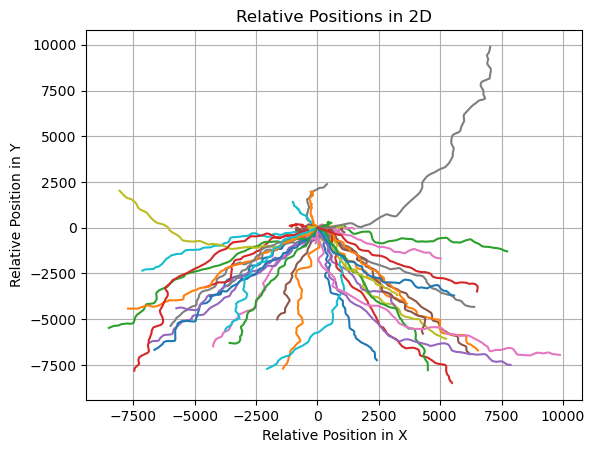

In [32]:
# Plot relative positions in 2D for each person
for person_name, positions in relative_positions.items():
    plt.plot(positions[:, 0], positions[:, 1], label=person_name)

plt.xlabel('Relative Position in X')
plt.ylabel('Relative Position in Y')
plt.title('Relative Positions in 2D')
plt.grid(True)
plt.show()

In [67]:
# Define the initial state and covariance matrices
initial_state_mean = [0, 0] # Initial position (x, y)
initial_state_covariance = [[1, 0], [0, 1]] # Initial uncertainty

# Define the transition and observation matrices
transition_matrices = [[1, 1], [0, 1]] # Simple linear motion model
observation_matrices = [[1, 0], [0, 1]] # Assuming direct observation of position

# Define the process and observation noise covariance matrices
transition_covariance = [[0.01, 0], [0, 0.01]] # Process noise
observation_covariance = [[0.1, 0], [0, 0.1]] # Observation noise

# Initialize the Kalman filter
kf = KalmanFilter(
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    transition_matrices=transition_matrices,
    observation_matrices=observation_matrices,
    transition_covariance=transition_covariance,
    observation_covariance=observation_covariance
)

# Example: Applying the Kalman filter to a single person's data
# Note: This is a simplified example. You'll need to adapt it to use your actual data.
person_name = 'p11' # Example person name
gyr_data = gyr_dict[person_name]
quat_data = quat_dict[person_name]
time_data = time_dict[person_name]

# Convert your data to the format expected by the Kalman filter
# This step depends on how you're using the quaternion and angular velocity data
# For simplicity, let's assume you're using the angular velocity to estimate position
# You'll need to adapt this to your specific use case
measurements = np.array([gyr_data['gyr_x'].values, gyr_data['gyr_y'].values]).T

# Apply the Kalman filter
state_means, state_covariances = kf.filter(measurements)


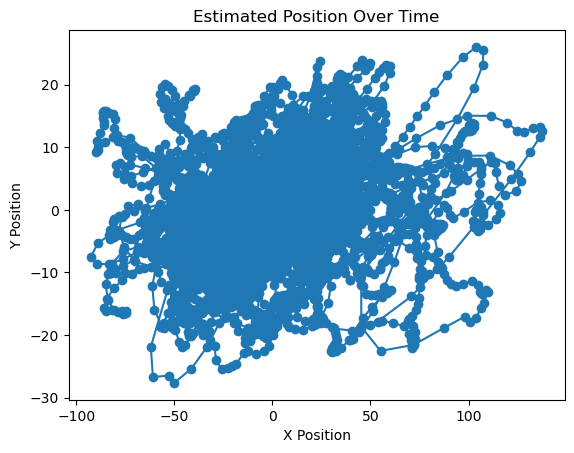

In [68]:
# Extract the x and y coordinates from the state_means array
x_coords = state_means[:, 0]
y_coords = state_means[:, 1]

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the estimated position
ax.plot(x_coords, y_coords, '-o')

# Add labels and title
ax.set(xlabel='X Position', ylabel='Y Position',
       title='Estimated Position Over Time')

# Show the plot
plt.show()

In [102]:
# System constants
deltat = 0.001  # sampling period in seconds (shown as 1 ms)
gyroMeasError = np.pi * (5.0 / 180.0)  # gyroscope measurement error in rad/s (shown as 5 deg/s)
gyroMeasDrift = np.pi * (0.2 / 180.0)  # gyroscope measurement error in rad/s/s (shown as 0.2 deg/s/s)
beta = np.sqrt(3.0 / 4.0) * gyroMeasError  # compute beta
zeta = np.sqrt(3.0 / 4.0) * gyroMeasDrift  # compute zeta

# Global system variables
a_x, a_y, a_z = 0, 0, 0  # accelerometer measurements
w_x, w_y, w_z = 0, 0, 0  # gyroscope measurements in rad/s
m_x, m_y, m_z = 0, 0, 0  # magnetometer measurements
SEq_1, SEq_2, SEq_3, SEq_4 = 1, 0, 0, 0  # estimated orientation quaternion elements with initial conditions
b_x, b_z = 1, 0  # reference direction of flux in earth frame
w_bx, w_by, w_bz = 0, 0, 0  # estimate gyroscope biases error

# Function to compute one filter iteration
def filter_update(w_x, w_y, w_z, a_x, a_y, a_z, m_x, m_y, m_z):
    global SEq_1, SEq_2, SEq_3, SEq_4, b_x, b_z, w_bx, w_by, w_bz

    # local system variables
    norm = 0.0  # vector norm
    SEqDot_omega_1, SEqDot_omega_2, SEqDot_omega_3, SEqDot_omega_4 = 0.0, 0.0, 0.0, 0.0  # quaternion rate from gyroscopes elements
    SEqHatDot_1, SEqHatDot_2, SEqHatDot_3, SEqHatDot_4 = 0.0, 0.0, 0.0, 0.0  # estimated direction of the gyroscope error
    w_err_x, w_err_y, w_err_z = 0.0, 0.0, 0.0  # estimated direction of the gyroscope error (angular)
    h_x, h_y, h_z = 0.0, 0.0, 0.0  # computed flux in the earth frame

    # axulirary variables to avoid repeated calculations
    halfSEq_1 = 0.5 * SEq_1
    halfSEq_2 = 0.5 * SEq_2
    halfSEq_3 = 0.5 * SEq_3
    halfSEq_4 = 0.5 * SEq_4
    twoSEq_1 = 2.0 * SEq_1
    twoSEq_2 = 2.0 * SEq_2
    twoSEq_3 = 2.0 * SEq_3
    twoSEq_4 = 2.0 * SEq_4
    twob_x = 2.0 * b_x
    twob_z = 2.0 * b_z
    twob_xSEq_1 = 2.0 * b_x * SEq_1
    twob_xSEq_2 = 2.0 * b_x * SEq_2
    twob_xSEq_3 = 2.0 * b_x * SEq_3
    twob_xSEq_4 = 2.0 * b_x * SEq_4
    twob_zSEq_1 = 2.0 * b_z * SEq_1
    twob_zSEq_2 = 2.0 * b_z * SEq_2
    twob_zSEq_3 = 2.0 * b_z * SEq_3
    twob_zSEq_4 = 2.0 * b_z * SEq_4
    twom_x = 2.0 * m_x
    twom_y = 2.0 * m_y
    twom_z = 2.0 * m_z
    SEq_1SEq_2 = SEq_1 * SEq_2
    SEq_1SEq_3 = SEq_1 * SEq_3
    SEq_1SEq_4 = SEq_1 * SEq_4
    SEq_3SEq_4 = SEq_3 * SEq_4
    SEq_2SEq_3 = SEq_2 * SEq_3
    SEq_2SEq_4 = SEq_2 * SEq_4

    # normalise the accelerometer measurement
    norm = np.sqrt(a_x * a_x + a_y * a_y + a_z * a_z)
    a_x /= norm
    a_y /= norm
    a_z /= norm

    # normalise the magnetometer measurement
    norm = np.sqrt(m_x * m_x + m_y * m_y + m_z * m_z)
    m_x /= norm
    m_y /= norm
    m_z /= norm

    # compute the objective function and Jacobian
    f_1 = twoSEq_2 * SEq_4 - twoSEq_1 * SEq_3 - a_x
    f_2 = twoSEq_1 * SEq_2 + twoSEq_3 * SEq_4 - a_y
    f_3 = 1.0 - twoSEq_2 * SEq_2 - twoSEq_3 * SEq_3 - a_z
    f_4 = twob_x * (0.5 - SEq_3 * SEq_3 - SEq_4 * SEq_4) + twob_z * (SEq_2SEq_4 - SEq_1SEq_3) - m_x
    f_5 = twob_x * (SEq_2 * SEq_3 - SEq_1 * SEq_4) + twob_z * (SEq_1 * SEq_2 + SEq_3 * SEq_4) - m_y
    f_6 = twob_x * (SEq_1SEq_3 + SEq_2SEq_4) + twob_z * (0.5 - SEq_2 * SEq_2 - SEq_3 * SEq_3) - m_z
    J_11or24 = twoSEq_3  # J_11 negated in matrix multiplication
    J_12or23 = 2.0 * SEq_4
    J_13or22 = twoSEq_1  # J_12 negated in matrix multiplication
    J_14or21 = twoSEq_2
    J_32 = 2.0 * J_14or21  # negated in matrix multiplication
    J_33 = 2.0 * J_11or24  # negated in matrix multiplication
    J_41 = twob_zSEq_3  # negated in matrix multiplication
    J_42 = twob_zSEq_4
    J_43 = 2.0 * twob_xSEq_3 + twob_zSEq_1  # negated in matrix multiplication
    J_44 = 2.0 * twob_xSEq_4 - twob_zSEq_2  # negated in matrix multiplication
    J_51 = twob_xSEq_4 - twob_zSEq_2  # negated in matrix multiplication
    J_52 = twob_xSEq_3 + twob_zSEq_1
    J_53 = twob_xSEq_2 + twob_zSEq_4
    J_54 = twob_xSEq_1 - twob_zSEq_3  # negated in matrix multiplication
    J_61 = twob_xSEq_3
    J_62 = twob_xSEq_4 - 2.0 * twob_zSEq_2
    J_63 = twob_xSEq_1 - 2.0 * twob_zSEq_3
    J_64 = twob_xSEq_2

    # compute the gradient (matrix multiplication)
    SEqHatDot_1 = J_14or21 * f_2 - J_11or24 * f_1 - J_41 * f_4 - J_51 * f_5 + J_61 * f_6
    SEqHatDot_2 = J_12or23 * f_1 + J_13or22 * f_2 - J_32 * f_3 + J_42 * f_4 + J_52 * f_5 + J_62 * f_6
    SEqHatDot_3 = J_12or23 * f_2 - J_33 * f_3 - J_13or22 * f_1 - J_43 * f_4 + J_53 * f_5 + J_63 * f_6
    SEqHatDot_4 = J_14or21 * f_1 + J_11or24 * f_2 - J_44 * f_4 - J_54 * f_5 + J_64 * f_6

    # normalise the gradient to estimate direction of the gyroscope error
    norm = np.sqrt(SEqHatDot_1 * SEqHatDot_1 + SEqHatDot_2 * SEqHatDot_2 + SEqHatDot_3 * SEqHatDot_3 + SEqHatDot_4 * SEqHatDot_4)
    SEqHatDot_1 /= norm
    SEqHatDot_2 /= norm
    SEqHatDot_3 /= norm
    SEqHatDot_4 /= norm

    # compute angular estimated direction of the gyroscope error
    w_err_x = twoSEq_1 * SEqHatDot_2 - twoSEq_2 * SEqHatDot_1 - twoSEq_3 * SEqHatDot_4 + twoSEq_4 * SEqHatDot_3
    w_err_y = twoSEq_1 * SEqHatDot_3 + twoSEq_2 * SEqHatDot_4 - twoSEq_3 * SEqHatDot_1 - twoSEq_4 * SEqHatDot_2
    w_err_z = twoSEq_1 * SEqHatDot_4 - twoSEq_2 * SEqHatDot_3 + twoSEq_3 * SEqHatDot_2 - twoSEq_4 * SEqHatDot_1

    # compute and remove the gyroscope biases
    w_bx += w_err_x * deltat * zeta
    w_by += w_err_y * deltat * zeta
    w_bz += w_err_z * deltat * zeta
    w_x -= w_bx
    w_y -= w_by
    w_z -= w_bz

    # compute the quaternion rate measured by gyroscopes
    SEqDot_omega_1 = -halfSEq_2 * w_x - halfSEq_3 * w_y - halfSEq_4 * w_z
    SEqDot_omega_2 = halfSEq_1 * w_x + halfSEq_3 * w_z - halfSEq_4 * w_y
    SEqDot_omega_3 = halfSEq_1 * w_y - halfSEq_2 * w_z + halfSEq_4 * w_x
    SEqDot_omega_4 = halfSEq_1 * w_z + halfSEq_2 * w_y - halfSEq_3 * w_x

    # compute then integrate the estimated quaternion rate
    SEq_1 += (SEqDot_omega_1 - (beta * SEqHatDot_1)) * deltat
    SEq_2 += (SEqDot_omega_2 - (beta * SEqHatDot_2)) * deltat
    SEq_3 += (SEqDot_omega_3 - (beta * SEqHatDot_3)) * deltat
    SEq_4 += (SEqDot_omega_4 - (beta * SEqHatDot_4)) * deltat

    # normalise quaternion
    norm = np.sqrt(SEq_1 * SEq_1 + SEq_2 * SEq_2 + SEq_3 * SEq_3 + SEq_4 * SEq_4)
    SEq_1 /= norm
    SEq_2 /= norm
    SEq_3 /= norm
    SEq_4 /= norm

    # compute flux in the earth frame
    SEq_1SEq_2 = SEq_1 * SEq_2  # recompute axulirary variables
    SEq_1SEq_3 = SEq_1 * SEq_3
    SEq_1SEq_4 = SEq_1 * SEq_4
    SEq_3SEq_4 = SEq_3 * SEq_4
    SEq_2SEq_3 = SEq_2 * SEq_3
    SEq_2SEq_4 = SEq_2 * SEq_4
    h_x = twom_x * (0.5 - SEq_3 * SEq_3 - SEq_4 * SEq_4) + twom_y * (SEq_2SEq_3 - SEq_1SEq_4) + twom_z * (SEq_2SEq_4 + SEq_1SEq_3)
    h_y = twom_x * (SEq_2SEq_3 + SEq_1SEq_4) + twom_y * (0.5 - SEq_2 * SEq_2 - SEq_4 * SEq_4) + twom_z * (SEq_3SEq_4 - SEq_1SEq_2)
    h_z = twom_x * (SEq_2SEq_4 - SEq_1SEq_3) + twom_y * (SEq_3SEq_4 + SEq_1SEq_2) + twom_z * (0.5 - SEq_2 * SEq_2 - SEq_3 * SEq_3)

    # normalise the flux vector to have only components in the x and z
    b_x = np.sqrt((h_x * h_x) + (h_y * h_y))
    b_z = h_z


In [110]:
# Iterate through the data
for file_name, person_name in zip(file_names, person_names):
    # Load the dataset
    data = pd.read_csv(os.path.join(data_directory, file_name))

    # Extract sensor data
    acc = np.array([data['Acc_X'], data['Acc_Y'], data['Acc_Z']])
    quat = np.array([data['Quat_X'], data['Quat_Y'], data['Quat_Z'], data['Quat_W']])
    mag = np.array([data['Mag_X'], data['Mag_Y'], data['Mag_Z']])

    # Iterate over each timestep
    for i in range(len(data)):
        # Extract sensor readings at the current timestep
        w_x, w_y, w_z = acc[:, i]
        a_x, a_y, a_z, a_w = quat[:, i]  # Make sure to include the scalar part of the quaternion
        m_x, m_y, m_z = mag[:, i]

        # Perform one iteration of the filter update
        filter_update(w_x, w_y, w_z, a_x, a_y, a_z, m_x, m_y, m_z)

        # Store the estimated orientation quaternion
        # You can store it in a list or array for further analysis or plotting

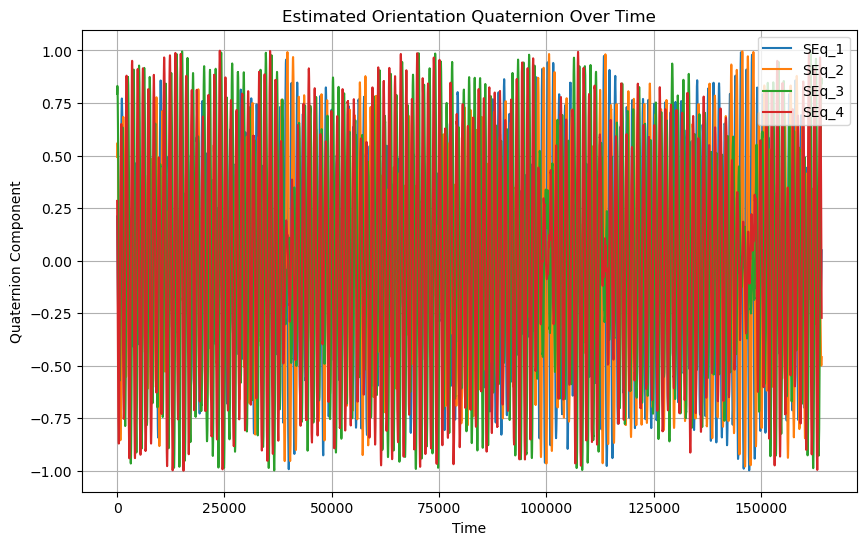

In [111]:
# Create lists to store quaternion components
quaternion_data = []

# Iterate through the data
for file_name, person_name in zip(file_names, person_names):
    # Load the dataset
    data = pd.read_csv(os.path.join(data_directory, file_name))

    # Extract sensor data
    acc = np.array([data['Acc_X'], data['Acc_Y'], data['Acc_Z']])
    quat = np.array([data['Quat_X'], data['Quat_Y'], data['Quat_Z'], data['Quat_W']])
    mag = np.array([data['Mag_X'], data['Mag_Y'], data['Mag_Z']])

    # Iterate over each timestep
    for i in range(len(data)):
        # Extract sensor readings at the current timestep
        w_x, w_y, w_z = acc[:, i]
        a_x, a_y, a_z, a_w = quat[:, i]  # Make sure to include the scalar part of the quaternion
        m_x, m_y, m_z = mag[:, i]

        # Perform one iteration of the filter update
        filter_update(w_x, w_y, w_z, a_x, a_y, a_z, m_x, m_y, m_z)

        # Store the estimated orientation quaternion
        quaternion_data.append([SEq_1, SEq_2, SEq_3, SEq_4])

# Convert the quaternion data to a NumPy array for easier manipulation
quaternion_data = np.array(quaternion_data)

# Plot the quaternion components over time
import matplotlib.pyplot as plt

# Extract time values
time_values = np.arange(len(quaternion_data))

# Plot each quaternion component
plt.figure(figsize=(10, 6))
plt.plot(time_values, quaternion_data[:, 0], label='SEq_1')
plt.plot(time_values, quaternion_data[:, 1], label='SEq_2')
plt.plot(time_values, quaternion_data[:, 2], label='SEq_3')
plt.plot(time_values, quaternion_data[:, 3], label='SEq_4')
plt.xlabel('Time')
plt.ylabel('Quaternion Component')
plt.title('Estimated Orientation Quaternion Over Time')
plt.legend()
plt.grid(True)
plt.show()


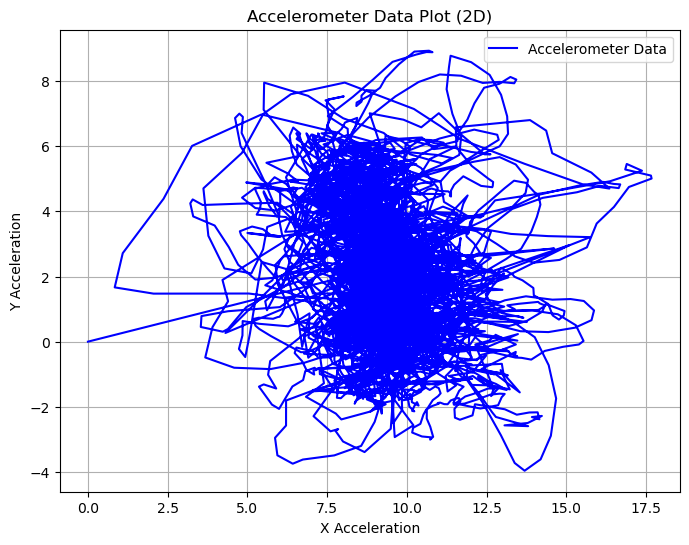

In [117]:
import matplotlib.pyplot as plt

# Iterate through the data
for file_name, person_name in zip(file_names, person_names):
    # Load the dataset
    data = pd.read_csv(os.path.join(data_directory, file_name))

    # Extract sensor data
    acc = np.array([data['Acc_X'], data['Acc_Y'], data['Acc_Z']])
    quat = np.array([data['Quat_X'], data['Quat_Y'], data['Quat_Z'], data['Quat_W']])
    mag = np.array([data['Mag_X'], data['Mag_Y'], data['Mag_Z']])

    # Iterate over each timestep
    for i in range(len(data)):
        # Extract sensor readings at the current timestep
        w_x, w_y, w_z = acc[:, i]
        a_x, a_y, a_z, a_w = quat[:, i]  # Make sure to include the scalar part of the quaternion
        m_x, m_y, m_z = mag[:, i]

        # Perform one iteration of the filter update
        filter_update(w_x, w_y, w_z, a_x, a_y, a_z, m_x, m_y, m_z)

        # Store the estimated orientation quaternion
        # You can store it in a list or array for further analysis or plotting

# Plot the x and y components of the accelerometer data
plt.figure(figsize=(8, 6))
plt.plot(acc[0], acc[1], label='Accelerometer Data', color='blue')
plt.xlabel('X Acceleration')
plt.ylabel('Y Acceleration')
plt.title('Accelerometer Data Plot (2D)')
plt.legend()
plt.grid(True)
plt.show()
